# RC44 yacht convergence
## Example
In cell below insert your initial parameters. If some of them are not required for your model, simply pass 0 value (for numbers). 
Some parameters are necessary only for specific cases like roughness (used by package when logarithmic profile is set) and they are omitted during computation. 

<div class="alert alert-block alert-warning"><b>ATTENTION:</b> do not delete keys in dictionaries and do not change their names. 
<br>
Make sure also that the length of your arrays match, like:  girths and chords</div>

More information can be found in code comments below.

In [1]:
import numpy as np
ns = np.array([5, 5, 5, 10, 10, 10, 10, 10, 10, 10, 10, 19, 20, 20, 20])
nc = np.array([2, 4, 8, 5, 6, 8 , 10, 11, 14, 15, 17, 10, 10, 11, 12])

In [3]:
# varaibles.py for jupyter
import os
import numpy as np
import time
from pySailingVLM.runner.container import Output, Rig, Conditions, Solver, MainSail, JibSail, Csys, Keel

mgirths =  np.array([0.00, 1./4, 1./2, 3./4, 1.00])
jgirths = np.array([0.00, 1./4, 1./2, 3./4, 1.00])

out = Output(case_name='my_case_name',
             case_dir=os.path.abspath(''),
             name=os.path.join("results_example_jib_and_mainsail_vlm", time.strftime("%Y-%m-%d_%Hh%Mm%Ss")),
            file_name='results_RC44_GENOA_VLM')


conditions = Conditions(leeway_deg=0.,    
                        heel_deg=13.,    
                        SOG_yacht=3.4460,  
                        tws_ref= 3.0860,     
                        alpha_true_wind_deg= 45., 
                        reference_water_level_for_wind_profile=-1.23,
                        wind_exp_coeff=0.1,
                        wind_reference_measurment_height=22.,
                        rho=1.184,
                        wind_profile='exponential',
                        roughness=0.05)
   
rig = Rig(main_sail_luff=17.52,
          jib_luff=17.40,
          foretriangle_height=16.98,
          foretriangle_base=5.13,
          sheer_above_waterline=1.23,
          boom_above_sheer=1.41,
          rake_deg=95.,
          mast_LOA=0.24,
          sails_def='jib_and_main')

main = MainSail(centerline_twist_deg=17. * mgirths + 0,
                girths=mgirths,
                chords=np.array([5.37, 4.98, 4.45, 3.72, 2.49]),
                camber= 1*np.array([0.028, 0.083, 0.095, 0.087, 0.013]),
                camber_distance_from_luff= np.array([0.5, 0.5, 0.5, 0.5, 0.5]))
                
jib = JibSail(centerline_twist_deg=24. * jgirths + 8.6,
             girths=jgirths,
             chords=np.array([7.32, 5.39, 3.55, 1.76, 0.09]),
             camber=1*np.array([0.055, 0.1, 0.13, 0.131, 0.01]),
             camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5]))

csys = Csys(reference_level_for_moments=np.array([0, 0, 0]))
keel = Keel(center_of_lateral_resistance_upright=np.array([0, 0, -1.25]))  


<div class="alert alert-block alert-warning">
<b>Run cell below twice:</b> Run cell below twice before running other cells. Output below is expected to always appear at first time importing pySailingVLM:
<br><br>
    
<em>   
/home/user/miniconda3/envs/mgr_test/lib/python3.10/site-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7f01d6a1e9e0 at 0x7f01d6cfa680>. Debug line information may be inaccurate.warnings.warn(NumbaDebugInfoWarning(msg))
</em> 
<br>
</div>

In [4]:
import shutil
from pySailingVLM.rotations.csys_transformations import CSYS_transformations
from pySailingVLM.yacht_geometry.hull_geometry import HullGeometry
from pySailingVLM.results.save_utils import save_results_to_file
from pySailingVLM.solver.panels_plotter import display_panels_xyz_and_winds
from pySailingVLM.results.inviscid_flow import InviscidFlowResults
from pySailingVLM.solver.vlm import Vlm
from pySailingVLM.runner.sail import Wind, Sail
from pySailingVLM.solver.panels_plotter import plot_cp

In [5]:
Fs_COG_x = np.zeros([ns.shape[0], 1])
Fs_COG_y = np.zeros([ns.shape[0], 1])
Fs_COG_z = np.zeros([ns.shape[0], 1])

for i, (n_spanwise, n_chordwise) in enumerate(zip(ns, nc)):
    
    solver = Solver(n_spanwise=n_spanwise,
                    n_chordwise=n_chordwise,
                    interpolation_type='spline')



    csys_transformations = CSYS_transformations(
        conditions.heel_deg, conditions.leeway_deg,
        v_from_original_xyz_2_reference_csys_xyz=csys.reference_level_for_moments)

    w = Wind(conditions)
    s = Sail(solver, rig, main, jib, csys_transformations)
    sail_set = s.sail_set
    hull = HullGeometry(rig.sheer_above_waterline, rig.foretriangle_base, csys_transformations, keel.center_of_lateral_resistance_upright)
    myvlm = Vlm(sail_set.panels, solver.n_chordwise, solver.n_spanwise, conditions.rho, w.profile, sail_set.trailing_edge_info, sail_set.leading_edge_info)

    inviscid_flow_results = InviscidFlowResults(sail_set, csys_transformations, myvlm)
    inviscid_flow_results.estimate_heeling_moment_from_keel(hull.center_of_lateral_resistance)
    

    _, df_integrals, _ = save_results_to_file(myvlm, csys_transformations, inviscid_flow_results, s.sail_set, out.name, out.file_name)
    Fs_COG_x[i] = df_integrals.loc[df_integrals['Quantity'] == 'F_sails_total_COG.x']['Value'].iloc[0]
    Fs_COG_y[i] = df_integrals.loc[df_integrals['Quantity'] == 'F_sails_total_COG.y']['Value'].iloc[0]
    Fs_COG_z[i] = df_integrals.loc[df_integrals['Quantity'] == 'F_sails_total_COG.z']['Value'].iloc[0]
    print(f'{i}/{ns.shape[0]}')

0/15
1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15


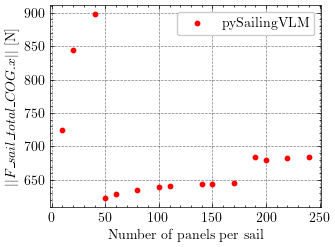

In [6]:
import matplotlib.pyplot as plt
import scienceplots 
%matplotlib inline

plt.style.use(['science', 'grid', 'bright'])

section_number = np.arange(1, myvlm.n_spanwise+1, 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)

n_of_panels_per_sail = ns*nc
ax1.scatter(n_of_panels_per_sail, np.linalg.norm(Fs_COG_x, axis=1), label='pySailingVLM', s=10, color='red')
plt.ylabel(r'$||F\_sail\_total\_COG.x||$ [N]')
plt.xlabel('Number of panels per sail')
plt.legend()

plt.savefig('fsx', dpi=300)
plt.show()

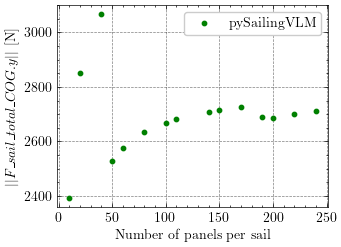

In [7]:
import matplotlib.pyplot as plt
import scienceplots 
%matplotlib inline

plt.style.use(['science', 'grid', 'high-vis'])

section_number = np.arange(1, myvlm.n_spanwise+1, 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)

n_of_panels_per_sail = ns*nc
ax1.scatter(n_of_panels_per_sail, np.linalg.norm(Fs_COG_y, axis=1), label='pySailingVLM', s=10, color='green')
plt.ylabel(r'$||F\_sail\_total\_COG.y||$ [N]')
plt.xlabel('Number of panels per sail')
plt.legend()

plt.savefig('fsy', dpi=300)
plt.show()

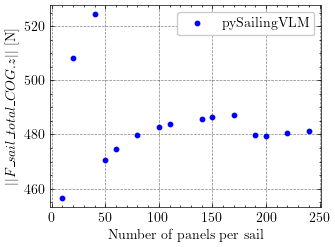

In [8]:
import matplotlib.pyplot as plt
import scienceplots 
%matplotlib inline

plt.style.use(['science', 'grid', 'high-vis'])

section_number = np.arange(1, myvlm.n_spanwise+1, 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)

n_of_panels_per_sail = ns*nc
ax1.scatter(n_of_panels_per_sail, np.linalg.norm(Fs_COG_z, axis=1), label='pySailingVLM', s=10, color='blue')
plt.ylabel(r'$||F\_sail\_total\_COG.z||$ [N]')
plt.xlabel('Number of panels per sail')
plt.legend()

plt.savefig('fsz', dpi=300)
plt.show()